In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import igraph as ix
import networkx as nx
import graphistry

In [3]:
data_path = '/public/npatil4/networks/data/combined/'

In [4]:
file_data = data_path + 'data_2015_withNodes_month.txt'
data_month = pd.read_csv(file_data,
                        sep='|')

In [5]:
data = data_month.groupby(['start','stop',
                           'pick_long','pick_lat',
                           'drop_long','drop_lat',
                           'month'],
                         as_index=False)['trips'].sum()

In [8]:
def data_limited2(df):
    
    mask = (
        (df.pick_long.between(-74.02,-73.92).values) & 
        (df.pick_lat.between(40.70,40.85).values) &
        (df.drop_long.between(-74.02,-73.92).values) & 
        (df.drop_lat.between(40.70,40.85).values) &
        (df.start!=df.stop)
        )
    
    return(mask)

##### Trips in manhattan

In [9]:
mask = (data_limited2(data))
print 'Routes : ',sum(mask)
print 'Trips : ',data.trips[mask].sum()

Routes :  45066210
Trips :  124275389


##### Trips in manhattan >=45

In [10]:
mask1 = (data_limited2(data)) & (data['trips']>=45)
print 'Routes : ',sum(mask1)
print 'Trips : ',sum(data.trips[mask1])

Routes :  80297
Trips :  5802170


##### Trips in manhattan <45

In [11]:
mask2 = (data_limited2(data)) & (data['trips']<45)
print 'Routes : ',sum(mask2)
print 'Trips : ',sum(data.trips[mask2])

Routes :  44985913
Trips :  118473219


##### Graph Generation and total nodes

In [17]:
data_nwk =nx.DiGraph()
data_nwk = nx.from_pandas_dataframe(df = data[mask],
                                    source='start',
                                    target='stop',
                                    edge_attr=['trips'],
                                    create_using=data_nwk)

In [14]:
data_nwk1 =nx.DiGraph()
data_nwk1 = nx.from_pandas_dataframe(df = data[mask1],
                                    source='start',
                                    target='stop',
                                    edge_attr=['trips'],
                                    create_using=data_nwk1)

In [15]:
data_nwk2 =nx.DiGraph()
data_nwk2 = nx.from_pandas_dataframe(df = data[mask2],
                                    source='start',
                                    target='stop',
                                    edge_attr=['trips'],
                                    create_using=data_nwk2)

In [18]:
{
    'All':data_nwk.number_of_nodes(),
    'Frequent':data_nwk1.number_of_nodes(),
    'in-frequent':data_nwk2.number_of_nodes()
}

{'All': 13804, 'Frequent': 1685, 'in-frequent': 13804}

#### Map geo-cordinates to census-tract

In [23]:
graph_census_tracts_2 = pd.read_csv('../data/graph_censusTract_full.txt',sep='|')
graph_census_tracts_2.columns = ['start_tract']+[str(x) for x in graph_census_tracts_2.columns[1:]]
for col in graph_census_tracts_2.columns:
    graph_census_tracts_2[col] = graph_census_tracts_2[col].astype('str')
    
    
graph_census_tracts_2['CENTLAT'] = graph_census_tracts_2.CENTLAT.astype('float')
graph_census_tracts_2['CENTLON'] = graph_census_tracts_2.CENTLON.astype('float')

In [37]:
data_use = data[mask].merge(graph_census_tracts_2[
                            ['CENTLAT','CENTLON','start_tract','GEOID']],
                left_on='start',right_on='start_tract').merge(
                            graph_census_tracts_2[
                            ['CENTLAT','CENTLON','start_tract','GEOID']],
                left_on='stop',right_on='start_tract')

In [38]:
columns = ['trips',
           'CENTLAT_x','CENTLON_x',
           'start_tract_x','GEOID_x',
           'CENTLAT_y','CENTLON_y',
           'start_tract_y','GEOID_y','month']

In [39]:
data_use=data_use[columns]

data_use.columns = ['trips',
                    'startLat','startLong',
                    'start_original','startGeoId',
                    'stopLat','stopLong',
                    'stop_original','stopGeoId','month']


data_use = data_use.groupby(['startGeoId','stopGeoId',
                             'startLat','startLong',
                             'stopLat','stopLong','month'],
                            as_index=False)['trips'].sum()

In [40]:
data_nwk3 = nx.DiGraph()
data_nwk3 = nx.from_pandas_dataframe(df = data_use[data_use.month==1],
                                    source='startGeoId',
                                    target='stopGeoId',
                                    edge_attr=['trips'],
                                    create_using=data_nwk3)

In [41]:
graph = data_nwk3


degree_in = graph.in_degree()
degree_out = graph.out_degree()
degree = graph.degree()
trips_out = {str(node) : sum(data_use[data_use.startGeoId==node].trips) 
             for node in graph.nodes()}
trips_in = {str(node) : sum(data_use[data_use.stopGeoId==node].trips) 
             for node in graph.nodes()}

In [43]:
pos_map = {}
for row_id,row in data_use.iterrows(): 
    pos_map[str(row[0])] = (float(row[3]),float(row[2]))
    pos_map[str(row[1])] = (float(row[5]),float(row[4]))

In [44]:
edges = data_use[['startGeoId','stopGeoId','trips']]

data_year_coordinates = [ [str(x),
                           degree[x],
                           degree_out[x],
                           degree_in[x],
                           trips_out[x],
                           trips_in[x],
                           pos_map[x][0],
                           pos_map[x][1]
                          ]
                          for x in graph.nodes()]

data_year_coordinates = pd.DataFrame(data_year_coordinates,
                                     columns=['node',
                                              'degree',
                                              'out_degree',
                                              'in_degree',
                                              'out_trips',
                                              'in_trips',
                                              'x',
                                              'y'
                                              ])

In [74]:
m = max(data_use.trips)
edgewidth = [d['trips']/m for (u,v,d) in graph.edges(data=True)]

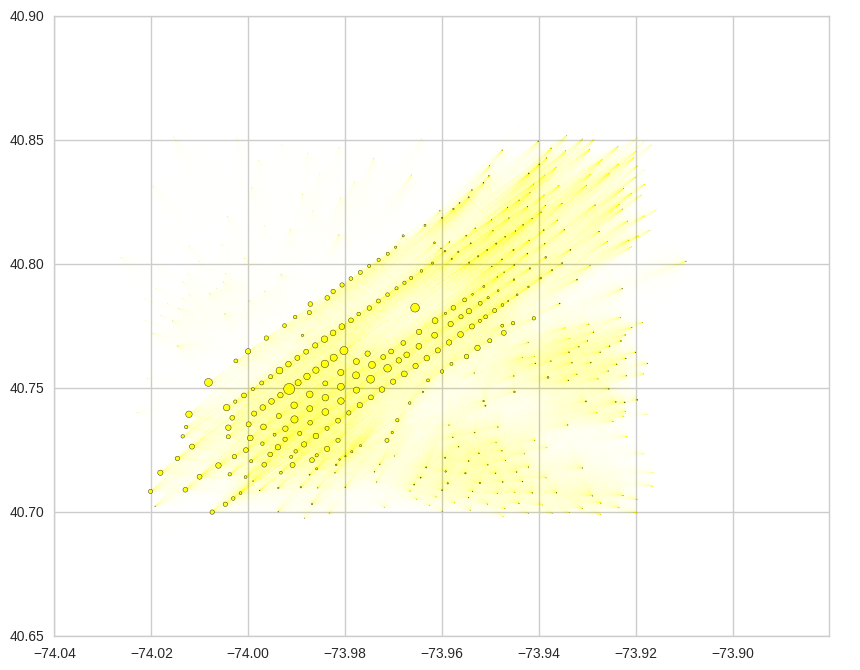

In [26]:
plt.figure(figsize=(10,8))
sns.set_style('whitegrid')

nx.draw_networkx_nodes(graph,
                 pos = pos_map,
                 node_list=[graph.nodes()],
                 node_size=[2.5*trips_out[key]/m for key in graph.nodes()],
                 node_color='yellow',
                 markeredgewidth=0.0,
                 alpha = 0.9)

nx.draw_networkx_edges(graph,
                 pos = pos_map,
                 alpha=0.1,
                 edge_color='yellow',
                 width = 0.008)

#sns.plt.ylim((40.70,40.82))
#sns.plt.xlim((-74.03,-73.92))
#plt.title('')

#plt.savefig('../plots/CircularLayout.png',dpi=800)

#### Upload data to graphistry

key = '6c13090d289176e8d77fe2f86bb27e07d0b7ce0b12e117d2dc5a67123e4ca52192e873b3ef53cf771f8619a651c1a156fa36c310979eb0f1998c9953e0868990'

graphistry.register(key=key)

bindings = graphistry.nodes(data_year_coordinates[['node','x','y']]).edges(edges).bind(source='startGeoId',
                                                                     destination='stopGeoId',
                                                                     node='node',
                                                                     edge_weight='trips')

bindings2 = bindings.settings(url_params={'play':0})

bindings2.plot()